In [7]:
import os
import pandas as pd
import numpy as np
import glob
import random

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

%config InlineBackend.figure_formatrmat = 'retina'

In [8]:
from stesml.data_tools import get_train_and_test_index
from stesml.data_tools import load_data
from stesml.data_tools import series_to_supervised
from stesml.data_tools import get_train_data
from stesml.data_tools import get_test_data

from stesml.model_tools import get_model
from stesml.model_tools import walk_forward_validation
from stesml.model_tools import get_predictions
from stesml.model_tools import get_progress
from stesml.model_tools import get_shuffle_results
from stesml.model_tools import get_T_from_h_results

from stesml.plot_tools import get_plot_data
from stesml.plot_tools import plot_test_results
from stesml.plot_tools import plot_average_error
from stesml.plot_tools import plot_progress_results

from stesml.postprocessing_tools import get_Cp
from stesml.postprocessing_tools import get_Ac
from stesml.postprocessing_tools import get_m
from stesml.postprocessing_tools import get_As
from stesml.postprocessing_tools import get_h
from stesml.postprocessing_tools import get_T

from stesml.data_tools import get_train_and_test_index_short
from stesml.data_tools import get_train_data_short

In [9]:
data_dir = "../data/Sulfur_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "ML_*_*.csv"))})

In [4]:
model_type = "XGBoost"
is_recurrent = False
n_estimators = 300
target = 'h'
per_case = False
x = 0

In [5]:
#train_index, test_index = get_train_and_test_index(scenario_index)

In [8]:
train_index, train_index_short, test_index = get_train_and_test_index_short(scenario_index)

In [9]:
t = 2000
X_train, y_train = get_train_data_short(scenario_index, train_index, train_index_short, target=target, t=t)
X_test, y_test = get_test_data(scenario_index, test_index, is_recurrent, target=target, x=x)

In [10]:
model = get_model(model_type, n_estimators)

In [11]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [12]:
y_hat = get_predictions(model, X_test, is_recurrent)

In [13]:
print(r2_score(y_test, y_hat))

0.9929403201089784


In [14]:
print(mean_squared_error(y_test, y_hat, squared=False))

4.562918198347933


In [15]:
test_df = load_data(scenario_index, test_index, x=x)

In [16]:
test_df[target+"_hat"] = y_hat

In [17]:
test_df_plot = get_plot_data(y_hat, test_df, test_index, is_recurrent, target=target)

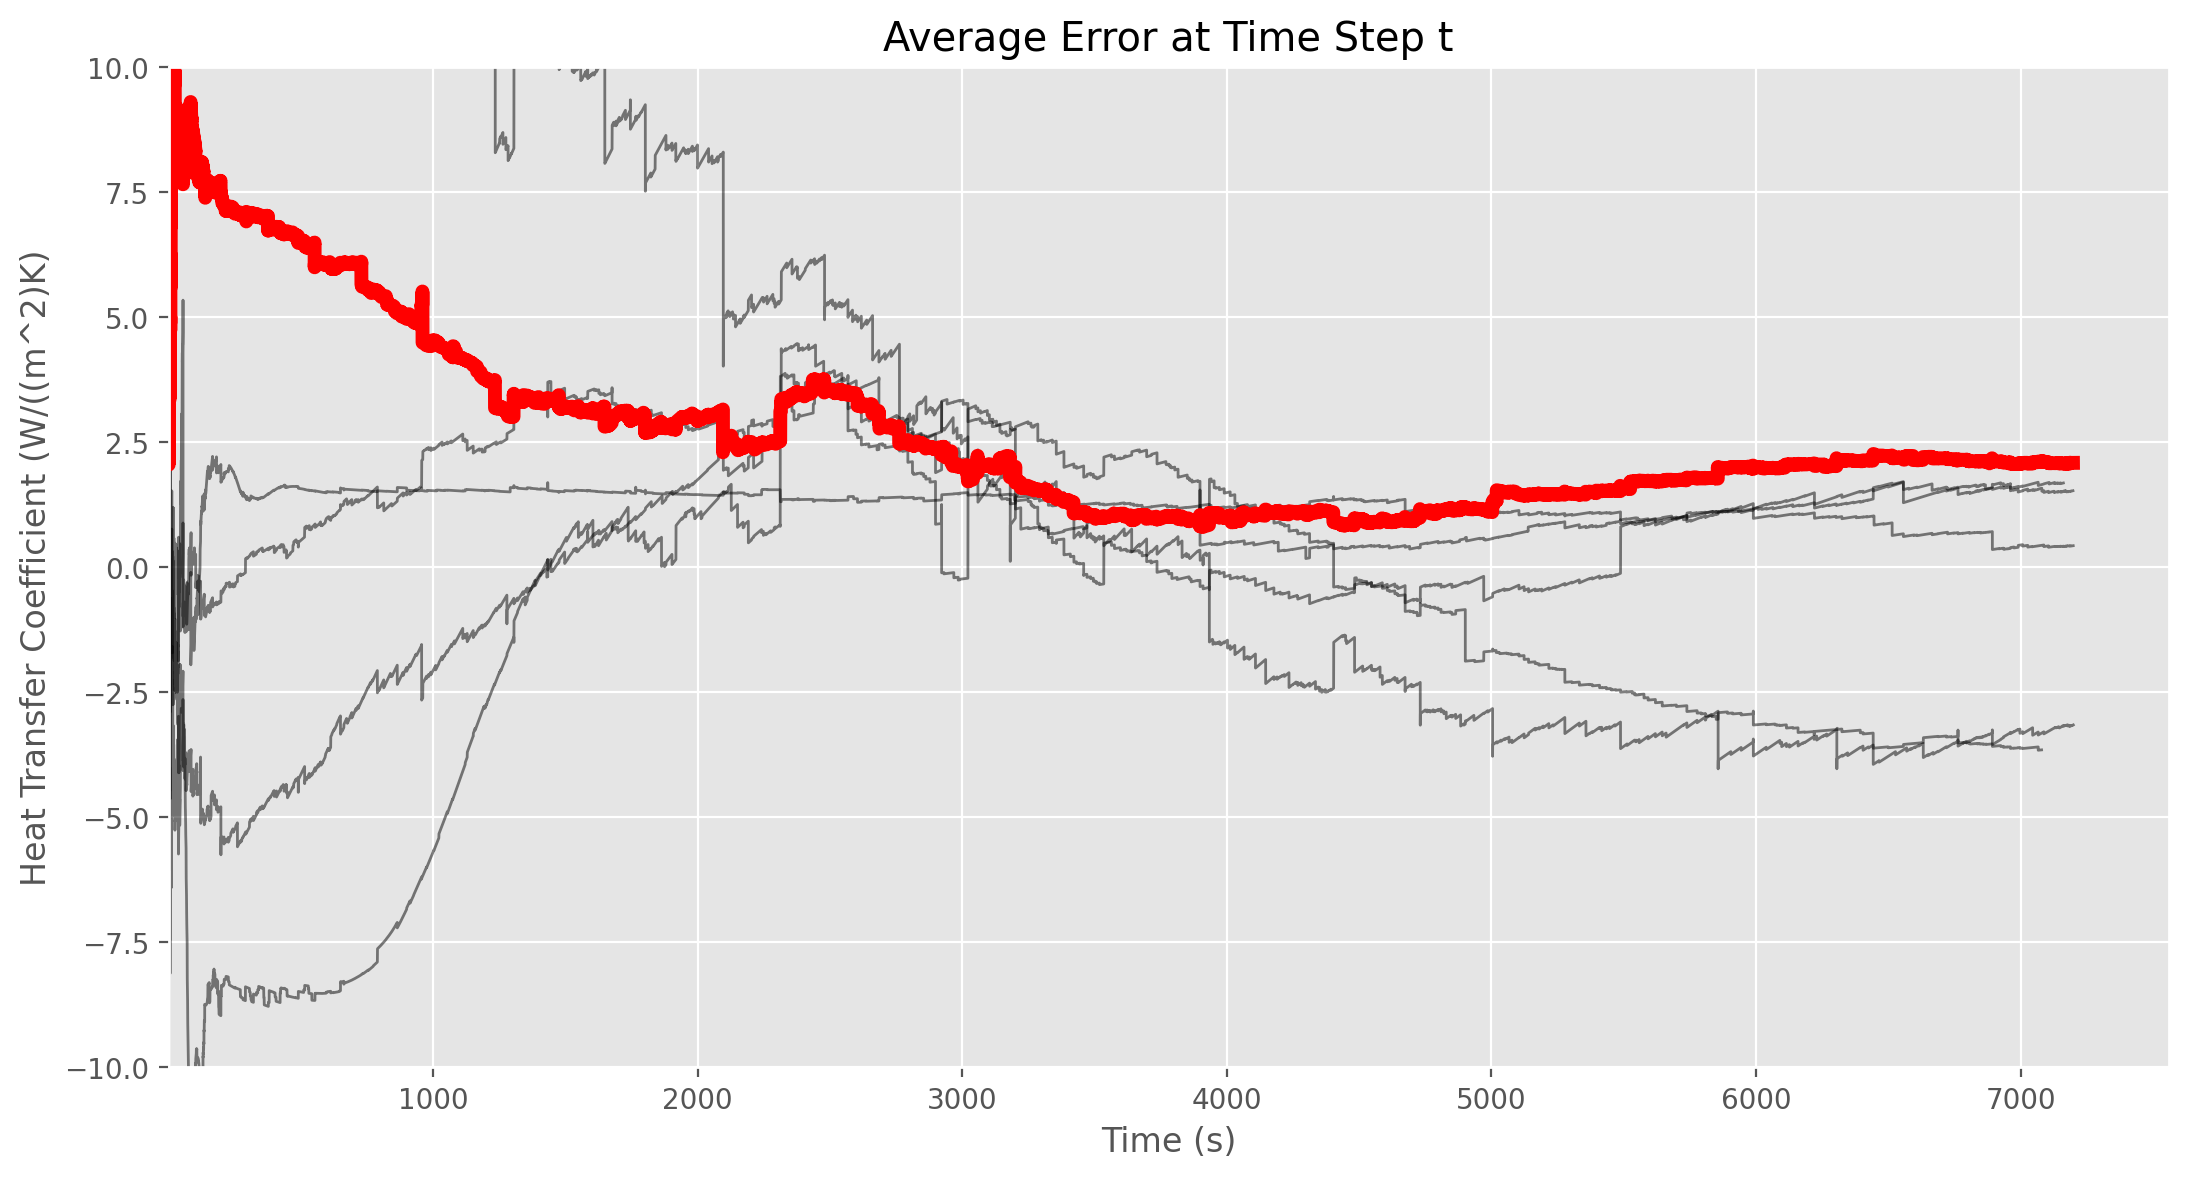

In [18]:
plot_average_error(test_df_plot, target=target)

<AxesSubplot:>

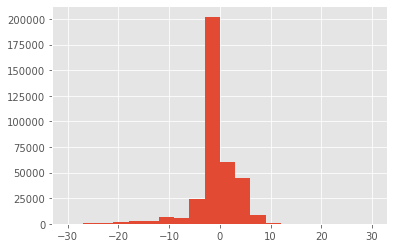

In [19]:
(test_df_plot[target] - test_df_plot[target+'_hat']).hist(bins=20, range=(-30, 30))

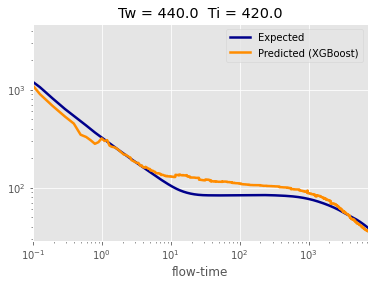

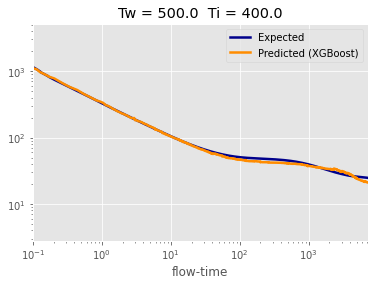

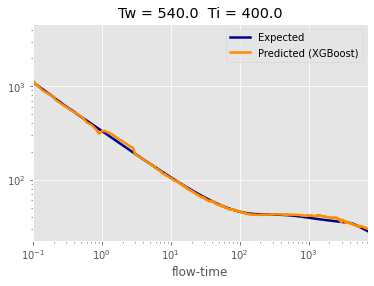

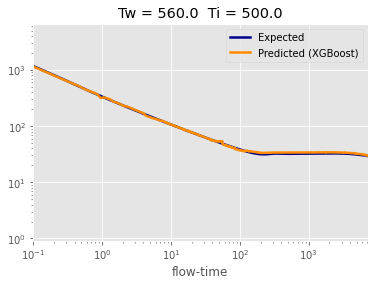

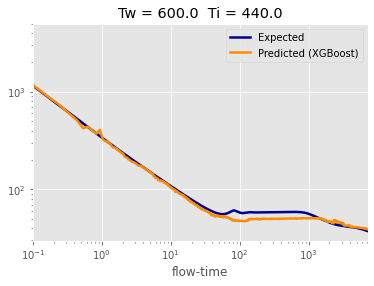

In [20]:
plot_test_results(test_df_plot, model_type, target=target)

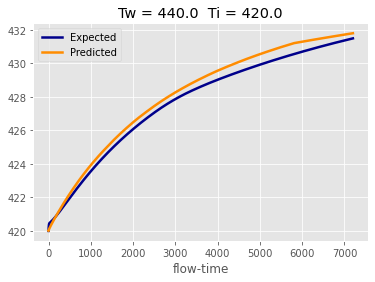

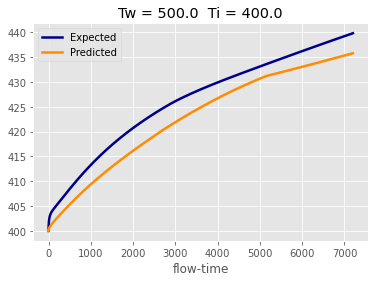

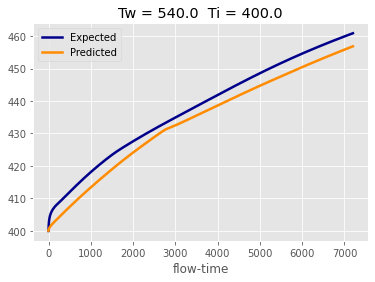

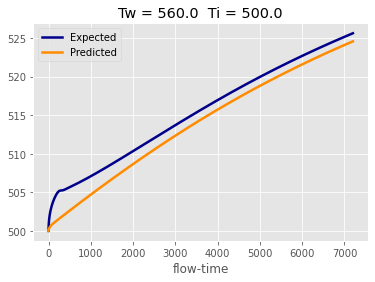

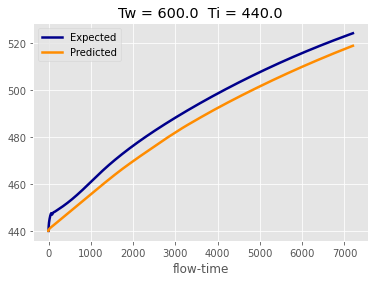

In [21]:
if target == 'h':
    rmse_T, r2_T = get_T_from_h_results(test_df, plot=True)

In [22]:
print(r2_T)

0.9914472300899962


In [23]:
print(rmse_T)

3.615445334853648


In [5]:
model_type = "XGBoost"
is_recurrent = False
target = 'Tavg'
per_case = False
x = 0

min_estimators = 100
max_estimators = 1000
step_size = 100
n_shuffle_iterations = 20

rmse_history, r2_history = get_progress(model_type, scenario_index, min_estimators, max_estimators, step_size, n_shuffle_iterations, is_recurrent, verbose=1, target=target, per_case=per_case, x=x)

Estimators: 100 Shuffle: 0 RMSE: 12.160723625929567 R2: 0.945041491463394
Estimators: 100 Shuffle: 1 RMSE: 10.737816079473408 R2: 0.9164462202071451
Estimators: 100 Shuffle: 2 RMSE: 10.18657588046308 R2: 0.926035848043426
Estimators: 100 Shuffle: 3 RMSE: 10.763187555791177 R2: 0.9008206508821999
Estimators: 100 Shuffle: 4 RMSE: 10.829881920718845 R2: 0.9022669006647751
Estimators: 100 Shuffle: 5 RMSE: 10.791686814743843 R2: 0.9096366294326431
Estimators: 100 Shuffle: 6 RMSE: 10.753734224036988 R2: 0.9145842150082016
Estimators: 100 Shuffle: 7 RMSE: 11.367316127426747 R2: 0.8915613947573552
Estimators: 100 Shuffle: 8 RMSE: 11.652609748436435 R2: 0.8908814747461018
Estimators: 100 Shuffle: 9 RMSE: 11.231159938503898 R2: 0.8950921441094613
Estimators: 100 Shuffle: 10 RMSE: 10.980706350446098 R2: 0.9021037158945304
Estimators: 100 Shuffle: 11 RMSE: 11.418684619705049 R2: 0.8979781740739682
Estimators: 100 Shuffle: 12 RMSE: 11.662522254878208 R2: 0.8802025742689422
Estimators: 100 Shuffle: 


KeyboardInterrupt



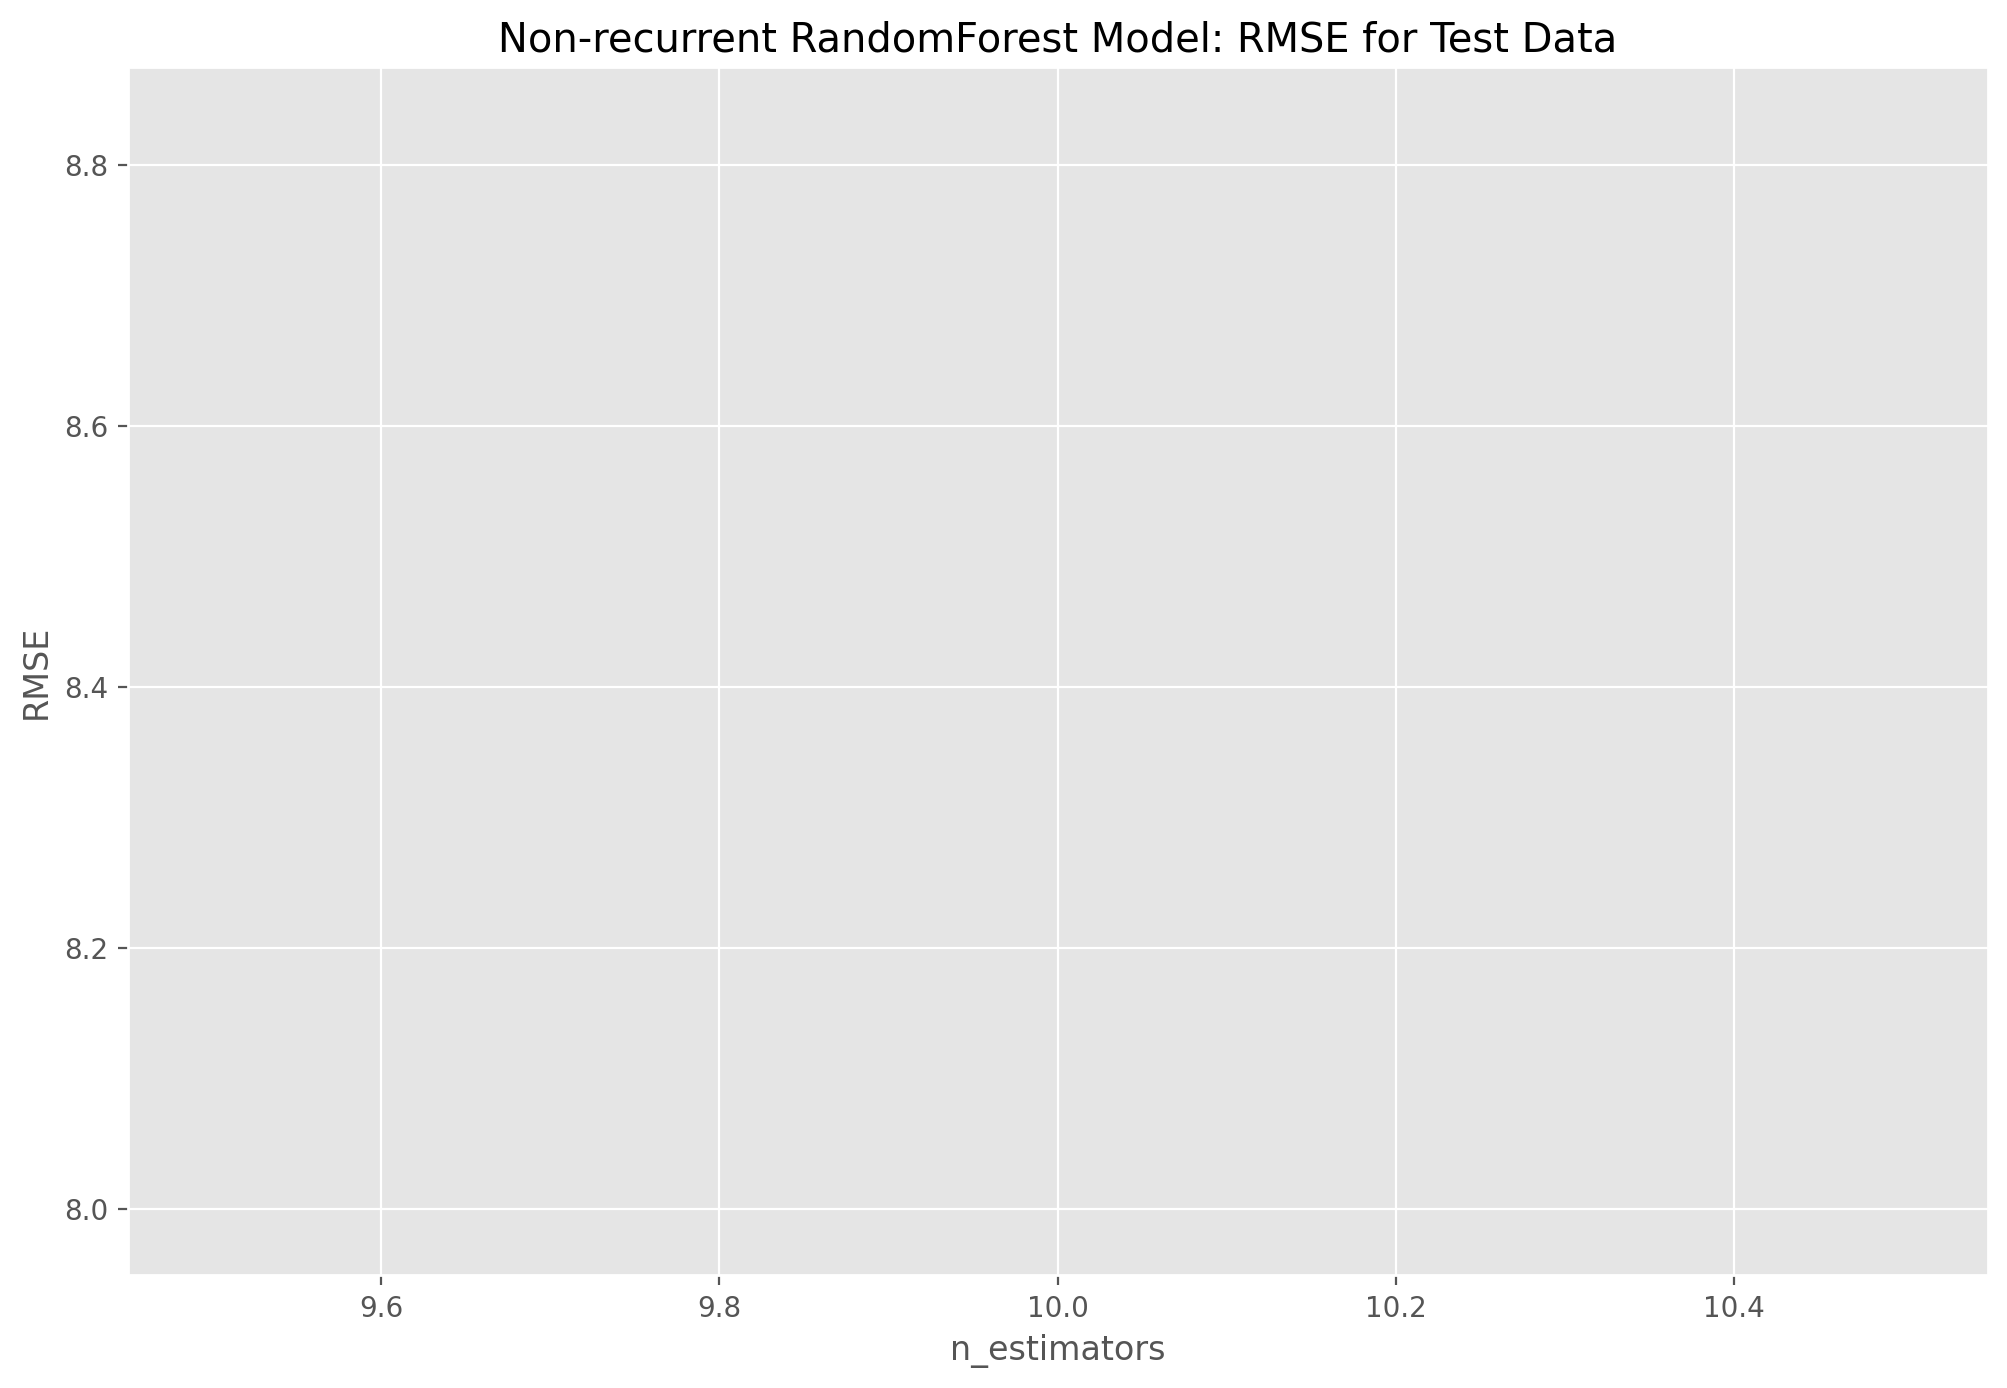

In [24]:
plot_progress_results(rmse_history, model_type, is_recurrent, metric="RMSE")

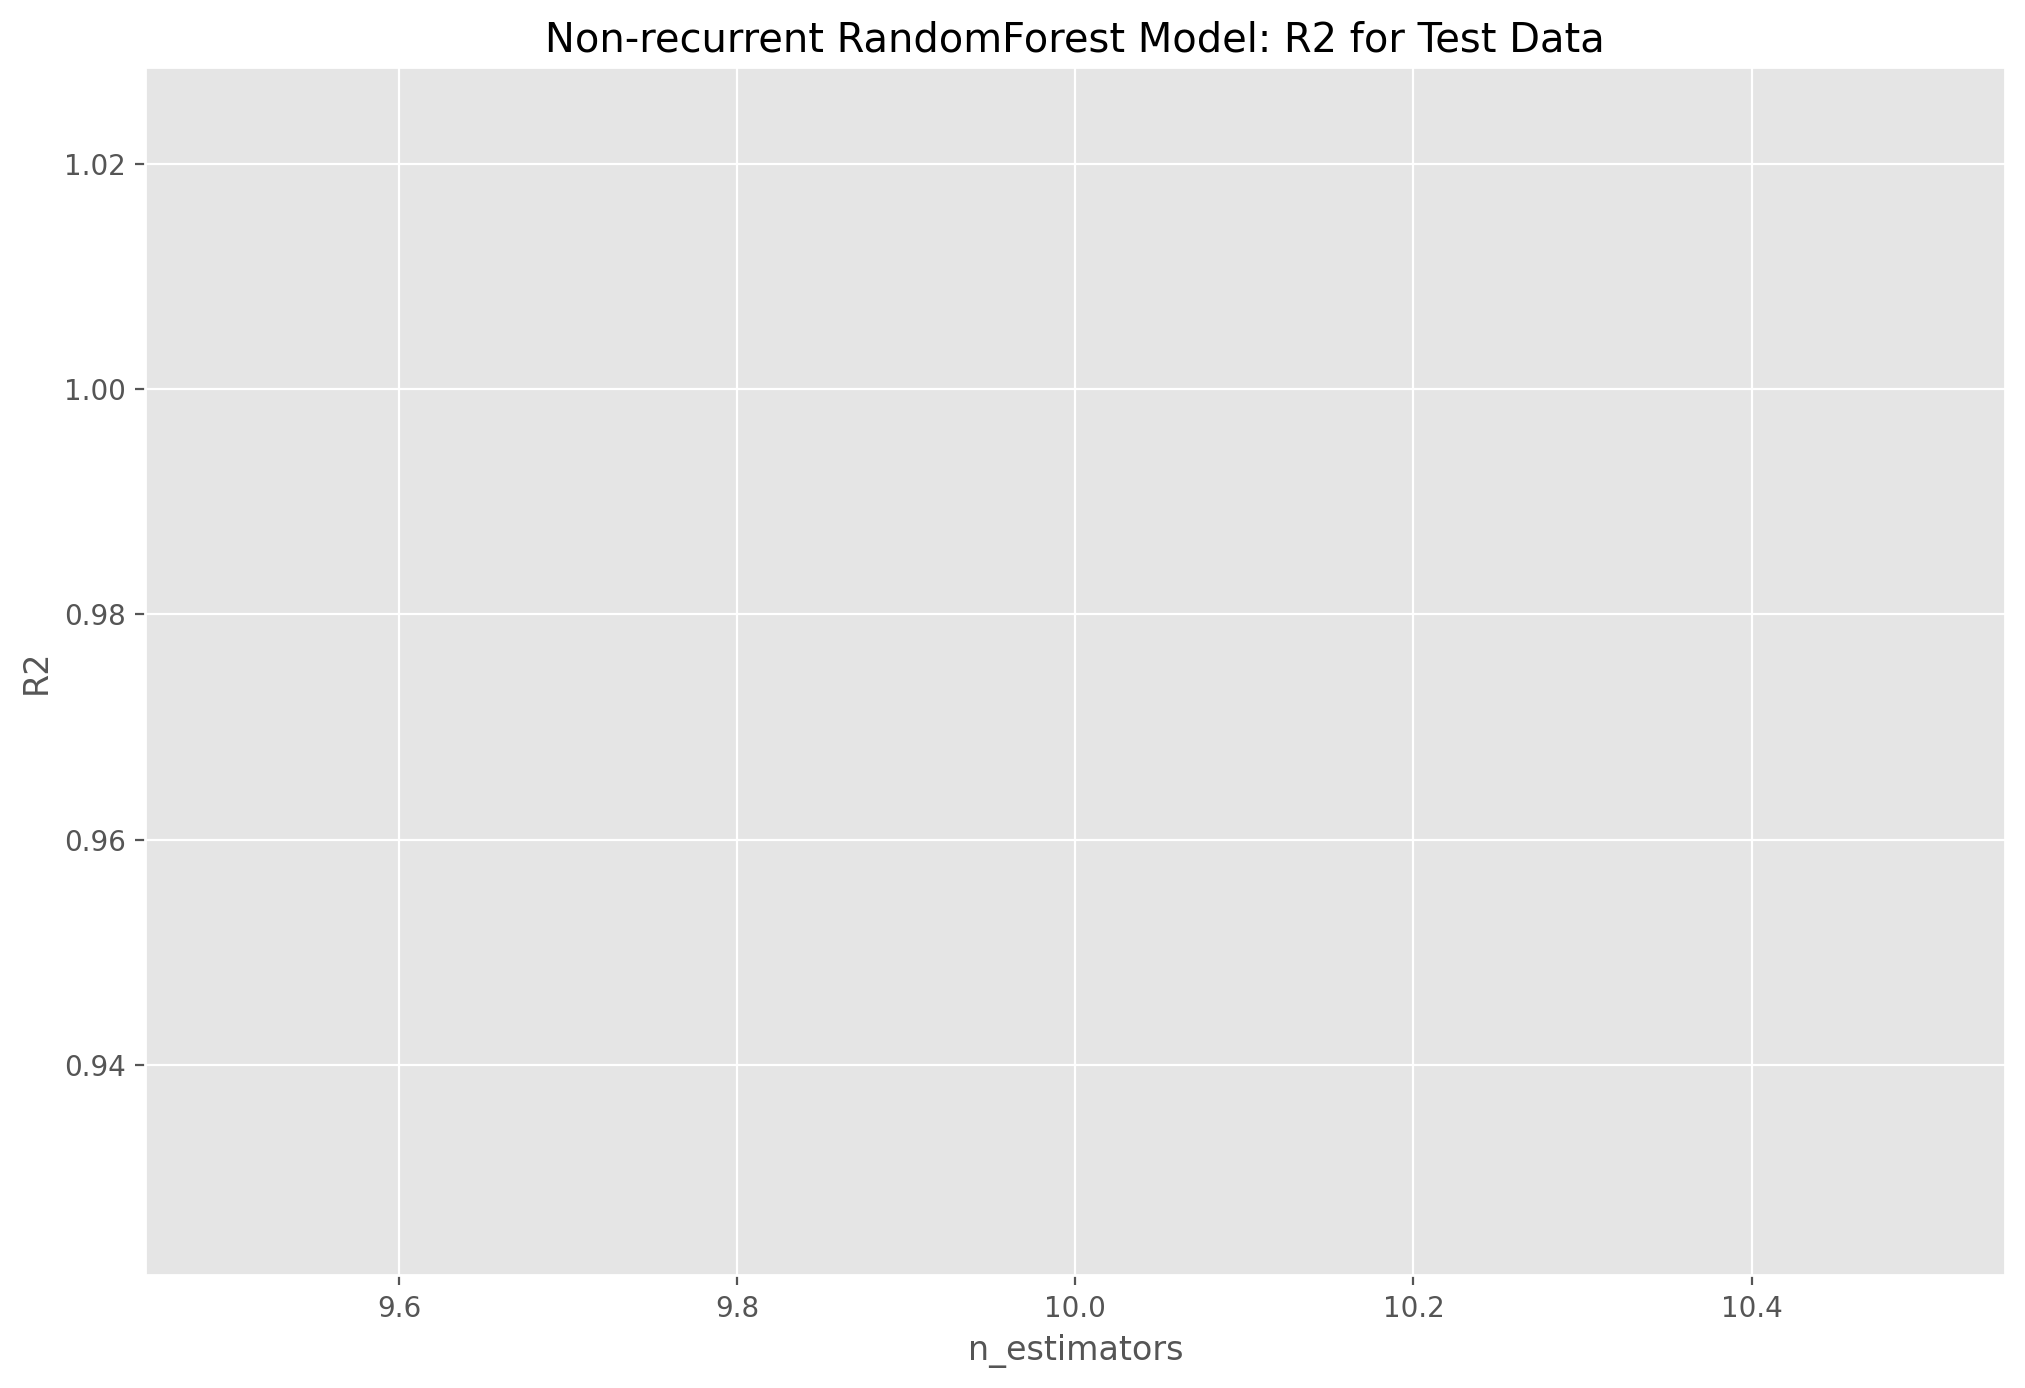

In [25]:
plot_progress_results(r2_history, model_type, is_recurrent, metric="R2")

In [26]:
model_type = 'RandomForest'
is_recurrent = False
target = 'h'
n_estimators = 10
n_shuffle_iterations = 1
per_case = False
x = 0

rmse_history, r2_history = get_shuffle_results(model_type, scenario_index, n_estimators, n_shuffle_iterations, is_recurrent, verbose=1, target=target, per_case=per_case, x=x, calc_T_from_h=True)

Estimators: 10 Shuffle: 0 RMSE: 8.16192993114114 R2: 0.9778114136395335
RMSE_T: 7.1823534425482665 R2_T: 0.923724220382037
# of Estimators: 10, RMSE = 8.16193, r2 = 0.97781
RMSE_T: 7.1823534425482665 R2_T: 0.923724220382037


In [26]:
model_type = 'XGBoost'
is_recurrent = False
target = 'h'
n_estimators = 300
n_shuffle_iterations = 20
per_case = False
x = 0
t = 7500

rmse_history, r2_history = get_shuffle_results(model_type, scenario_index, n_estimators, n_shuffle_iterations, is_recurrent, verbose=1, target=target, per_case=per_case, x=x, calc_T_from_h=True, short=True, t=t)

Estimators: 300 Shuffle: 0 RMSE: 7.480402601836106 R2: 0.9832015929115966
RMSE_T: 6.531221341891428 R2_T: 0.9743040988780117
Estimators: 300 Shuffle: 1 RMSE: 5.260795979849019 R2: 0.9902773858534444
RMSE_T: 6.280489901029837 R2_T: 0.969165164986191
Estimators: 300 Shuffle: 2 RMSE: 9.92268918921352 R2: 0.9550681188482127
RMSE_T: 5.922979166248401 R2_T: 0.970066643516433
Estimators: 300 Shuffle: 3 RMSE: 8.904829126201289 R2: 0.9636861637988265
RMSE_T: 5.514843754581301 R2_T: 0.9657717270693216
Estimators: 300 Shuffle: 4 RMSE: 7.916335843396004 R2: 0.9699307720042245
RMSE_T: 4.8796660784065775 R2_T: 0.9720251171497433
Estimators: 300 Shuffle: 5 RMSE: 7.84970522938984 R2: 0.9719990232456724
RMSE_T: 4.907212857910818 R2_T: 0.9744165071195824
Estimators: 300 Shuffle: 6 RMSE: 7.219440188199125 R2: 0.9755199008241318
RMSE_T: 4.843156083697612 R2_T: 0.9763074287550425
Estimators: 300 Shuffle: 7 RMSE: 6.875999134597167 R2: 0.9778290749455507
RMSE_T: 5.00082549094493 R2_T: 0.9766138868798744
Esti